**# Step 1 - Install the Natural Language Toolkit (NLTK) library:**

In [ ]:
! pip install nltk

**# Step 2 - Import all necessary libraries:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score
from sklearn.ensemble import RandomForestClassifier
import string
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

**# Step 3 - Load the spam dataset:**

In [53]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3364,ham,"Sorry, I'll call later",NaN,NaN,NaN
4267,ham,Hey so whats the plan this sat?,NaN,NaN,NaN
2956,ham,I would but I'm still cozy. And exhausted from...,NaN,NaN,NaN
559,ham,Aiyo... U always c our ex one... I dunno abt m...,NaN,NaN,NaN
3206,ham,This phone has the weirdest auto correct.,NaN,NaN,NaN


**# Step 4 - Explore the dataset structure:**

In [54]:
print(df.info())
print("\n", df.describe())
print("\n", df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None

           v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                               Unnamed: 2  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G o o d n i g h t . . .@"   
freq                                                    3   

                   Unnamed: 3 Unnamed: 4  
count          

C:\Users\WDT\AppData\Local\Temp\ipykernel_940\555269384.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.countplot(x= df["v1"], palette= cols)


Text(0, 0.5, 'Number of Data points')

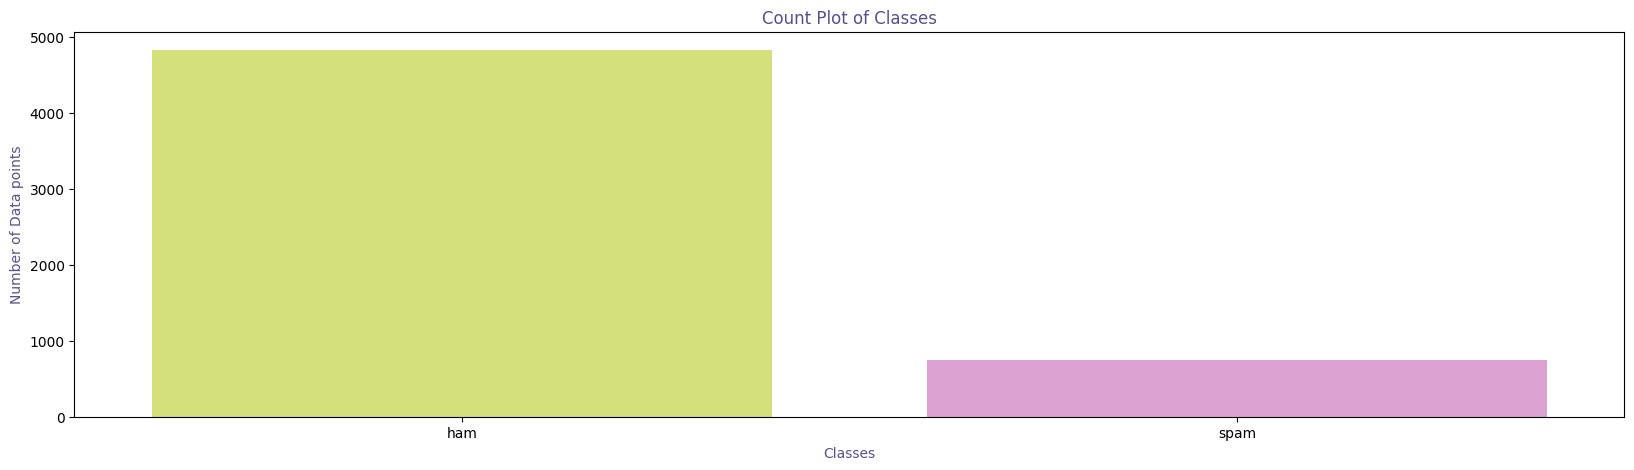

In [55]:
cols= ["#E1F16B", "#E598D8"]
plt.figure(figsize=(20,5))
fg = sns.countplot(x= df["v1"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

**# Step 5 - Data cleaning and preparing:**

In [56]:
to_drop = [col for col in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] if col in df.columns]
df.drop(columns=to_drop, inplace=True, axis=1)

df.rename(columns={'v1':'Target', 'v2':'Text'}, inplace=True)
df.sample(5)

,Target,Text
3604,ham,Jordan got voted out last nite!
2142,ham,You see the requirements please
263,spam,Hey I am really horny want to chat or see me n...
81,ham,K. Did you call me just now ah?
3804,ham,Dude while were makin those weirdy brownies my...


In [57]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])
df.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [58]:
print("Duplicated = ", df.duplicated().sum(), "\n")
print(df.isnull().sum())

Duplicated =  403 

Target    0
Text      0
dtype: int64


In [59]:
df.drop_duplicates()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [60]:
print("Duplicated = ", df.duplicated().sum(), "\n")
print("Shape = ", df.shape)

Duplicated =  403 

Shape =  (5572, 2)


In [61]:
df['Target'].value_counts()

Target
0    4825
1     747
Name: count, dtype: int64

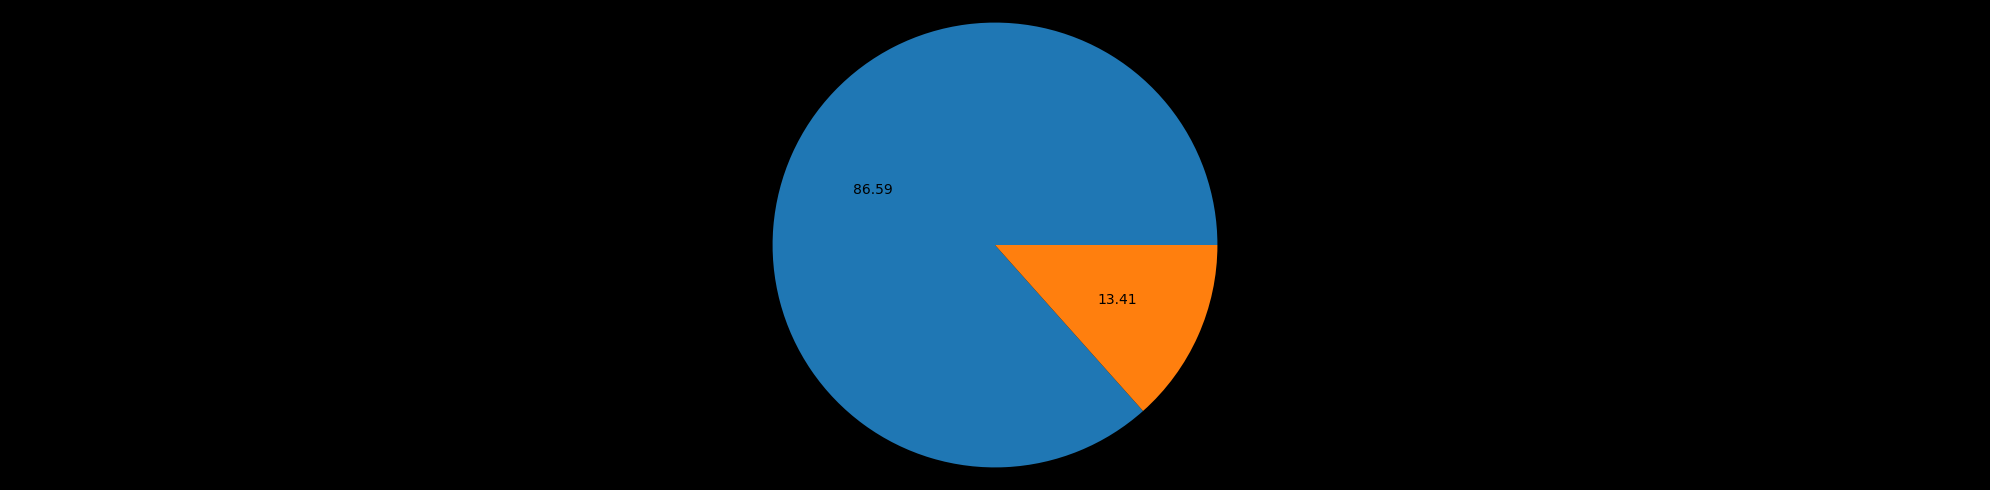

In [62]:
plt.figure(figsize=(20,5), facecolor='black')
plt.pie(df['Target'].value_counts(), labels=['Ham','Spam'],autopct="%0.2f")
plt.axis('equal')
plt.tight_layout()
plt.show()

**# Step 6 - Data balancing and transformation:**

In [63]:
ps = PorterStemmer()
ps.stem('loving')

'love'

In [64]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [65]:
df['transformed_text'] = df['Text'].apply(transform_text)
df.head()

,Target,Text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


**# Step 7 - Initialize vectorizers to convert text into numerical vectors:**

In [66]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['Target'].values

**# Step 8 - Data splitting and model Initializaton:**

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

rfc = RandomForestClassifier(n_estimators=50, random_state=2)

**# Step 9 - Training the Random Forest Classifier:**

In [68]:
def train_classifier(rfc,X_train,y_train,X_test,y_test):
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [69]:
accuracy, precision = train_classifier(rfc, X_train,y_train,X_test,y_test)

print("For Random Forest Classifier: ")
print("Accuracy - ", accuracy)
print("Precision - ", precision)

For Random Forest Classifier: 
Accuracy -  0.9695067264573991
Precision -  1.0


**# Step 10 - Saving models:**

In [72]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(rfc,open('model.pkl','wb'))